In this chapter, we build a reusable class that will create windows of data. APplying deep learning for forecasting relies on creating appropriate time windows and specifying the inputs and labels.

Implementing the DataWindow Class

The class is based on the width of the input, the width of the label, and the shift.
The width of the input is simply the number of timesteps that are fed into the model
to make predictions.

The label width is equivalent to the number of timesteps in the predictions. If we
predict only one timestep, the label width is 1. 

The shift is the number of timesteps that the model is shifted to make predictions. It's the number of steps seprating input and the predictions. If we predict only one timestep, the shift is 1. The window size equals the sum of the input width and the label width.

In [1]:
import pandas as pd

train_df = pd.read_csv(r"C:\Users\user\ML Resources-code\Machine-Learning\Deep Learning Time Series Forecasting\train.csv")

test_df = pd.read_csv(r"C:\Users\user\ML Resources-code\Machine-Learning\Deep Learning Time Series Forecasting\test.csv")

val_df = pd.read_csv(r"C:\Users\user\ML Resources-code\Machine-Learning\Deep Learning Time Series Forecasting\val.csv")

In [2]:
print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 

class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)  #3 rows, 1 column, nth index 
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64) #will appear as small dots in the plot
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):  #use tf timeseries_dataset_from_array to make sliding windows 
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):  #create a sample batch to cache within the class
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

            

Split our window between inputs and labels, in order for the models to make predictions based on the inputs and measure the error metric against the labels.

The last main piece of logic will
format our dataset into tensors so that they can be fed to our deep learning models.
TensorFlow comes with a very handy function called timeseries_dataset_from_
array, which we use to create a dataset of sliding windows, given an array.

We conclude our DataWindow class by defining some properties to apply the
make_dataset function on the training, validation, and testing sets. We also created a
sample batch that we’ll cache within the class for plotting purposes

-----------------------------------------------------------------------------------------------------------------------

Aplying baseline Models

Single-step baseline model

The input is one time step. The output is the prediction of the next timestep. Generate a window of data, with an input width of 1 and a label width of 1. The shift willl also be one. Target variable is the volumme of traffic. 

In [4]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume'])

wide_window = DataWindow(input_width=24, label_width = 24, shift =1, label_columns=['traffic_volume'])

In this situation, the simplest prediction we can make is the last observed value. Basically,
the prediction is simply the input data point. This is implemented by the class
Baseline.

In [5]:
from tensorflow.keras import Model, Sequential

class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:  #no target specified, return all columns. Useful for multi-output models
            return inputs 
        
        elif isinstance(self.label_index, list): #returns only the specified columns, if list is specified. useful for multioutput models
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:,:, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:,:, self.label_index]
        return result[:,:, tf.newaxis]  #return the input for a given target variable 

In [6]:
from tensorflow.keras.losses import MeanSquaredError

from tensorflow.keras.metrics import MeanAbsoluteError 

column_indices  = {name: i for i, name in enumerate (train_df.columns)} #generates a dict with name and index of each column

baseline_last = Baseline(label_index=column_indices['traffic_volume']) #pass the index of the target column in the Baseline class

baseline_last.compile(loss= MeanSquaredError(), metrics = [MeanAbsoluteError()])

In [7]:
#evaluate perfomance of the model on the validation set and the test set


val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137 - mean_absolute_error: 0.0839 


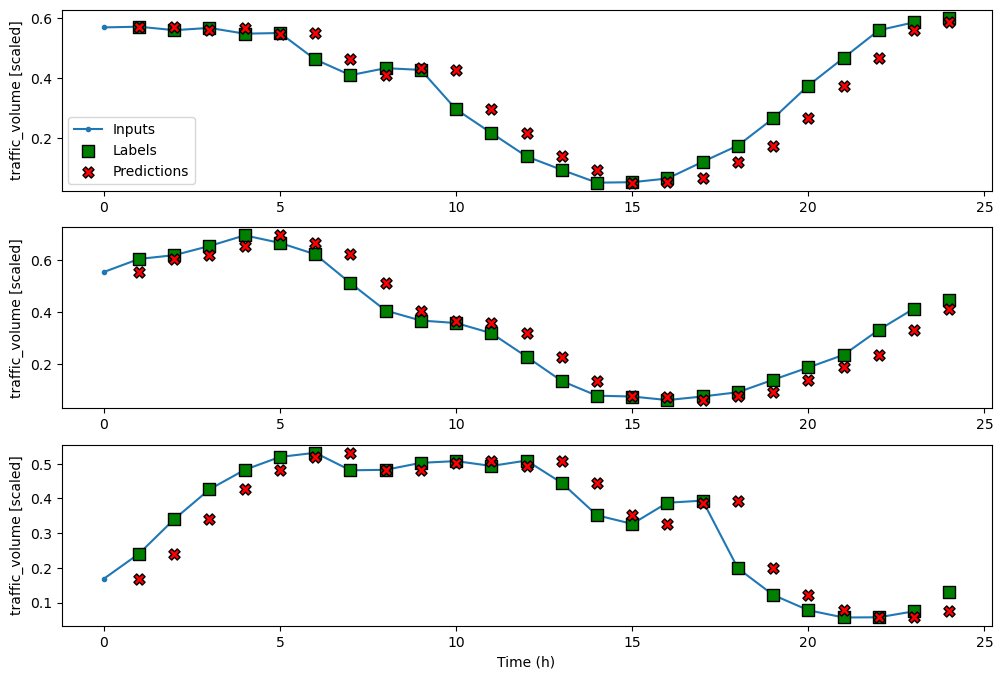

In [8]:
#call the plot method from the DataWindow class to visualize predictions 

wide_window.plot(baseline_last)

The crosses at each timestep are the last known value.

In [9]:
#prnt the MAE of the baseline 

print(performance['Baseline - Last'][1])

0.08128399401903152


Multi-Step baseline Models

In [10]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

Predicting the last known Value 

In [13]:
class MultiSTepBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__() 
        self.label_index = label_index

    def call (self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :],[1,24,1]) #if no target specified, return last known value of all columns over the next 24 hours
        #expand dimesnions of the last time step value before tiling 
        expanded = tf.expand_dims(inputs[:, -1:,self.label_index], axis=1)
        return tf.tile(expanded, [1,24,1]) #return last known value of the target column over the next 24 timesteps (hours)
    

In [14]:
ms_baseline_last = MultiSTepBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_last.compile(loss= MeanSquaredError(), metrics = [MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)

ms_performance['Baseline- Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1493 - mean_absolute_error: 0.3085


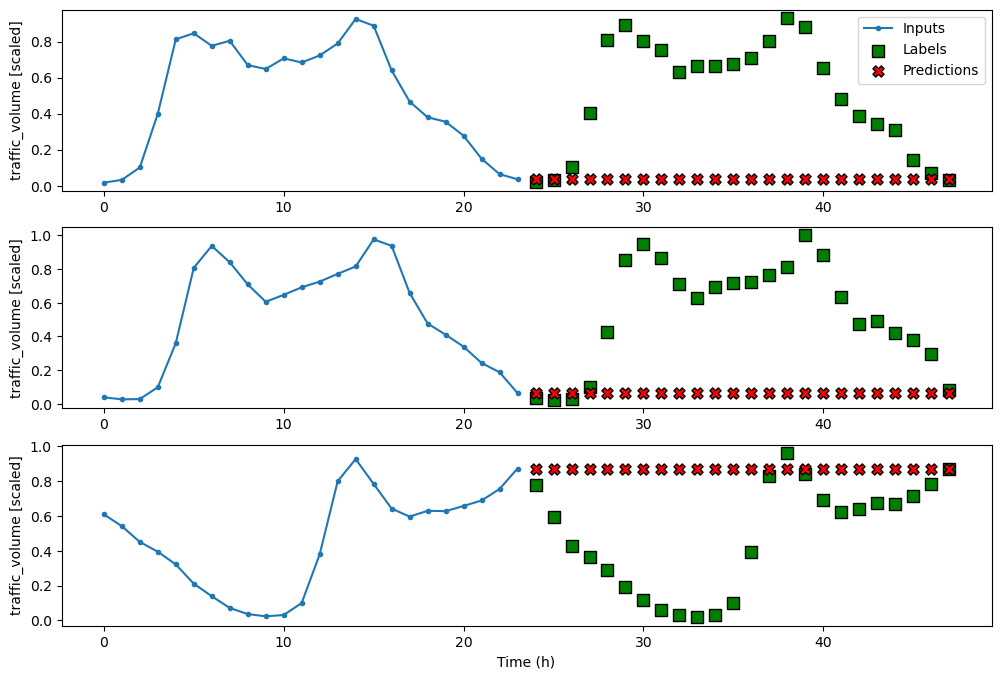

In [15]:
multi_window.plot(ms_baseline_last)

In [16]:
print(ms_performance['Baseline- Last'][1])

0.3020646274089813


The predictions which are shown as crosses, correspond to the last value of the input sequence. 

Repeating the Input Sequence

In [17]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:,:, self.label_index:] #return the input sequence for the target variable/column 

In [19]:
#initialize the baseline model and generate predictions 
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)

ms_performance['Baseline- Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1693 - mean_absolute_error: 0.3033 


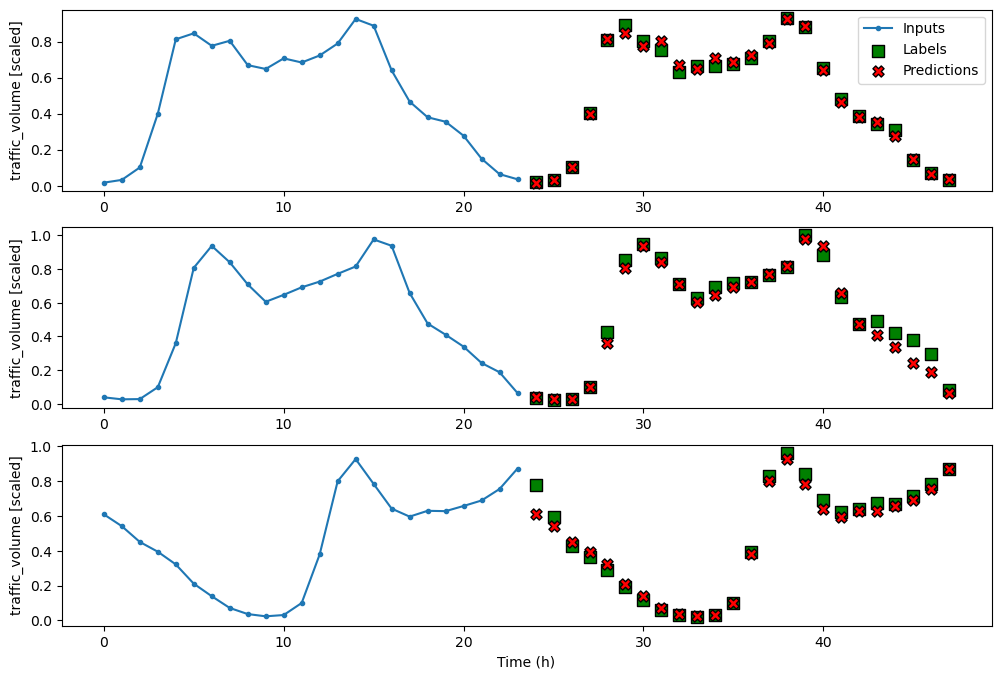

In [20]:
multi_window.plot(ms_baseline_repeat)


With the repeat input sequence as the predictions, the predictions match exactly the input sequence. Many predictions overlap the labels meaning the baseline performs well. 

In [21]:
print(ms_performance['Baseline- Repeat'][1]) # THIS IS A BETTER BASELINE 

0.2945353388786316


Multi-Output baseline model

We will try to predict the traffic volume and the temperature for the next timestep using a single input. By applying a single step on both of them, we have our multi-output model.  

we’ll define two windows:
one for training and the other for visualization. Since the model takes in one
data point and outputs one prediction, we want to initialize a wide window of data to
visualize many predictions over many timesteps.

In [22]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp', 'traffic_volume'])

mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp', 'traffic_volume'])

In [23]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs # if no target specified, return input as is(all columns). Useful for multioutputs 
        
        elif isinstance(self.label_index, list): #returns specified list of targets. Used for multioutput models 
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:,:, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]  #return the input for a given target variable
    
    

In [25]:
print(column_indices.keys())


dict_keys(['temp', 'clouds_all', 'traffic_volume', 'day_sin', 'day_cos'])


In [26]:
#pass the indices of the trafffic volume and temp columns to output the last know value for the respective variables

print(column_indices['traffic_volume'])

print(column_indices['temp'])

2
0


In [30]:
mo_baseline_last = Baseline(label_index=[0, 2])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [31]:
mo_val_performance = {}

mo_performance = {}

mo_val_performance ['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)

mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - mean_absolute_error: 0.0484


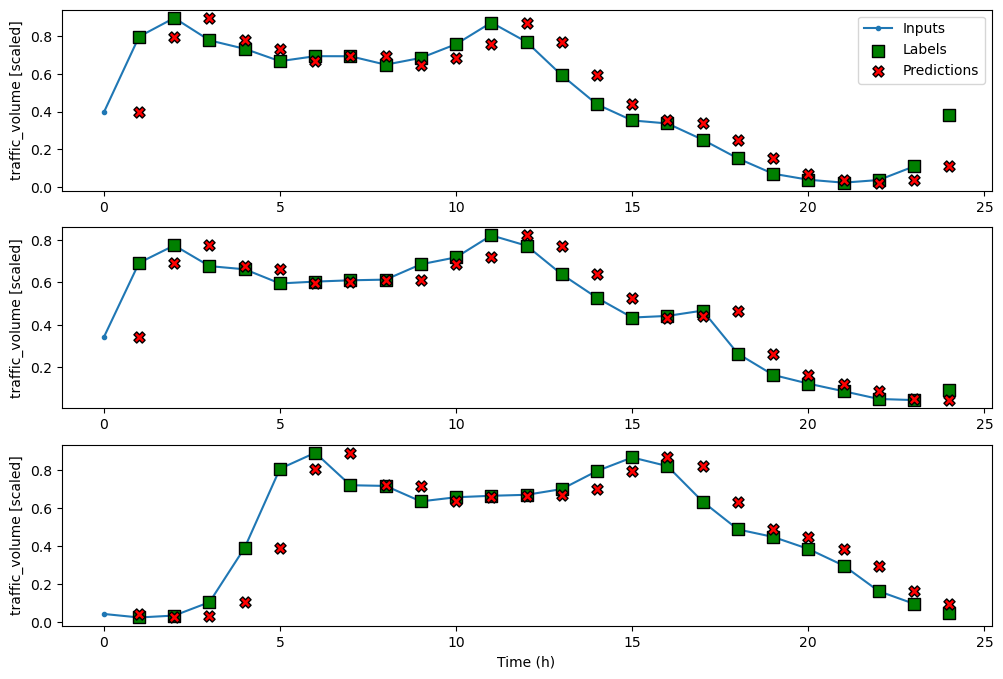

In [32]:
mo_wide_window.plot(mo_baseline_last)

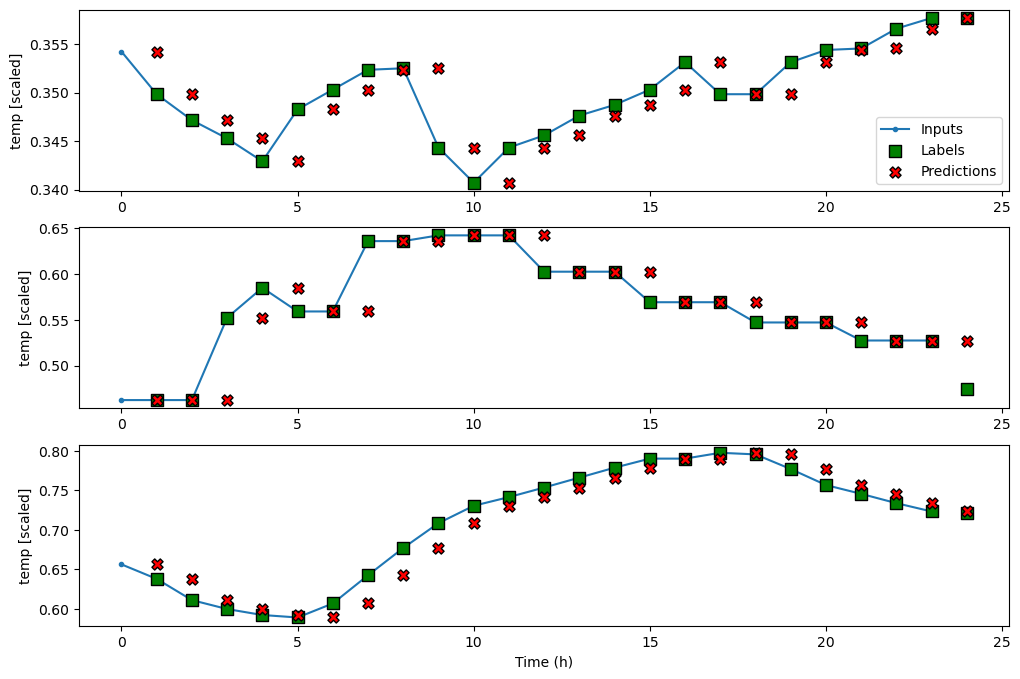

In [33]:
mo_wide_window.plot(mo_baseline_last, plot_col='temp')

In [34]:
print(mo_performance['Baseline - Last'])

[0.006438457407057285, 0.04710666462779045]


An MAE of 0.047 is obtained on the test set. 